# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

##### 🔴Imports

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import time 

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

# 🔵🔵🔵Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

#### 🔴Data Import and Exploration

In [2]:
# Load in the general demographics data
azdias = pd.read_csv('./data/Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file
feat_info = pd.read_csv('./data/AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data 
display(azdias.head())
print('Shape of demographics data: ', azdias.shape)
print(azdias.dtypes)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Shape of demographics data:  (891221, 85)
AGER_TYP                  int64
ALTERSKATEGORIE_GROB      int64
ANREDE_KZ                 int64
CJT_GESAMTTYP           float64
FINANZ_MINIMALIST         int64
                         ...   
PLZ8_HHZ                float64
PLZ8_GBZ                float64
ARBEIT                  float64
ORTSGR_KLS9             float64
RELAT_AB                float64
Length: 85, dtype: object


In [4]:
# Display feature information 
display(feat_info)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


# 🔵🔵🔵Step 1: Preprocessing

## 🔵🔵Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### 🔵Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

#### 🔴Identify missing or unknown data values and convert to NaNs



In [5]:
# Calculate naturally missing values (NaN) for later use
nat_nan = azdias.isnull().sum().sum()

In [6]:
# Helper function
def convert_nan(column):
    # Extract list of encodings from feat_info for feature
    codes_str = list(feat_info[feat_info['attribute'] == column.name]['missing_or_unknown'])[0]
    
    # Parse string
    codes = codes_str.replace('[', '').replace(']', '').split(',')
    
    # Replace missing value with NaN
    return column.apply(lambda x: np.NaN if str(x) in codes else x)

In [7]:
azdias = azdias.apply(convert_nan)

#### 🔴 Compare Naturally Missing Data vs Categorised as Missing

In [8]:
total_nan = azdias.isnull().sum().sum()
non_nat_nan = azdias.isnull().sum().sum() - nat_nan
total_values = azdias.size
percent_non_nat_nan = 100 * non_nat_nan / total_values
percent_nat_nan = 100 * nat_nan / total_values
percent_nan = 100 * total_nan / total_values
print('Data that are categorised as "missing" or "unknown": {}, ({}%)'.format(non_nat_nan, round(percent_non_nat_nan, 2)))
print('Data that are naturally missing: {}, ({}%)'.format(nat_nan, round(percent_nat_nan, 2)))
print('Total NaN: {}, ({}%)'.format(percent_nan, round(percent_nan, 2)))

Data that are categorised as "missing" or "unknown": 1632228, (2.15%)
Data that are naturally missing: 4896838, (6.46%)
Total NaN: 8.61879838743371, (8.62%)


#### 🔵Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

- Are there any patterns in which columns have, or share, missing data?

#### 🔴Identify Hard Outliers (~40-80% NaN)

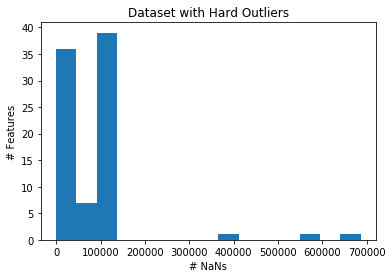

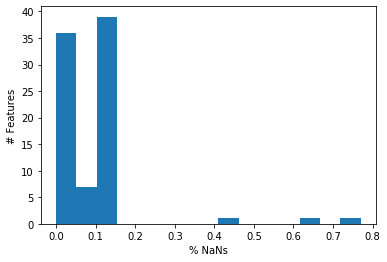

In [9]:
# Plot histogram of # NaN 
total_nan_cols = azdias.isnull().sum()                 # NaNs per Column
n, bins, patches = plt.hist(total_nan_cols, bins=15)   # Plot Histogram
plt.ylabel('# Features')
plt.xlabel('# NaNs')  
plt.title('Dataset with Hard Outliers')
plt.show()

# Plot histogram of % NaN
ptotal_nan_cols = (azdias.isnull().mean())
n, bins, patches = plt.hist(ptotal_nan_cols, bins=15)
plt.ylabel('# Features')
plt.xlabel('% NaNs')
plt.show()

In [10]:
# Identify Outliers
outliers_index = list(ptotal_nan_cols[(ptotal_nan_cols > 0.4)].index)
outliers_value = list(ptotal_nan_cols[(ptotal_nan_cols > 0.4)].values)
print('Outliers (many NaNs): \n')

outliers = pd.Series(outliers_value, outliers_index)
display(pd.DataFrame(outliers, columns = ['Proportion of NaNs']))

Outliers (many NaNs): 



,Proportion of NaNs
AGER_TYP,0.769554
GEBURTSJAHR,0.440203
KK_KUNDENTYP,0.655967


In [11]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


#### 🔴Drop Hard Outliers (from azdias and feat_info)

In [12]:
# Create new dataset without hard outliers
azdias_1 = azdias.drop(outliers_index, axis=1)

print('Dropped {} features.'.format(azdias.shape[1] - azdias_1.shape[1]))

Dropped 3 features.


In [13]:
# Create new feat_info without hard outliers (for later use)
drop_index = []

for i in range(feat_info.shape[0]):
    if feat_info['attribute'][i] in outliers_index:
        drop_index.append(i)

feat_info_1 = feat_info.drop(drop_index, axis=0)
print('Dropped {} features.'.format(feat_info.shape[0] - feat_info_1.shape[0]))

Dropped 3 features.


#### 🔴Identify Soft Outliers (~8-15% NaN)

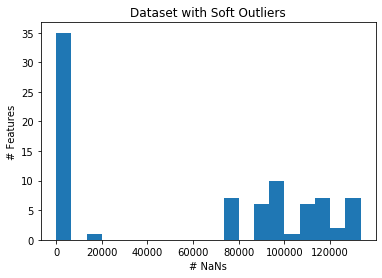

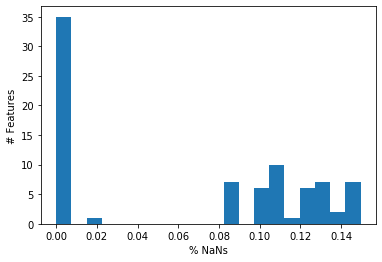

In [14]:
# # Plot soft histogram of # NaN 
total_nan_cols_soft = azdias_1.isnull().sum()                 # Define NaNs per Column
n, bins, patches = plt.hist(total_nan_cols_soft, bins=20)     # Plot Histogram
plt.ylabel("# Features")
plt.xlabel("# NaNs")  
plt.title('Dataset with Soft Outliers')
plt.show()

# # Plot soft histogram of % NaN 
ptotal_nan_cols_soft = (azdias_1.isnull().mean())
n, bins, patches = plt.hist(ptotal_nan_cols_soft, bins=20)
plt.ylabel('# Features')
plt.xlabel('% NaNs')
plt.show()

In [15]:
# Identify Soft Outliers
outliers_index_soft = list(ptotal_nan_cols[(ptotal_nan_cols > 0.08) & (ptotal_nan_cols < 0.16)].index)
outliers_value_soft = list(ptotal_nan_cols[(ptotal_nan_cols > 0.08) & (ptotal_nan_cols < 0.16)].values)

# Define series and display
outliers_soft = pd.Series(outliers_value_soft, outliers_index_soft)
outliers_soft = pd.DataFrame(outliers_soft, columns = ['Proportion of NaNs'])
display(outliers_soft)

,Proportion of NaNs
HEALTH_TYP,0.124768
NATIONALITAET_KZ,0.121536
PRAEGENDE_JUGENDJAHRE,0.121366
SHOPPER_TYP,0.124768
SOHO_KZ,0.082470
TITEL_KZ,0.082470
VERS_TYP,0.124768
ALTER_HH,0.082470
ANZ_PERSONEN,0.082470
ANZ_TITEL,0.082470


#### 🔴Identify Patterns in Soft Outliers

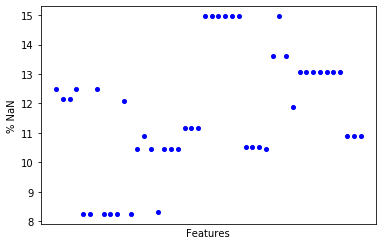

In [16]:
# Plot number of NaNs vs Corresponding Feature
plt.plot(outliers_soft.index, 100*outliers_soft.values, 'bo', markersize=4)
plt.ylabel('% NaN')
plt.xlabel('Features')
plt.tick_params(
    axis='x',          
    bottom=False,      
    top=False,         
    labelbottom=False) 

#??????
plt.rcParams['figure.figsize'] = 10, 3


plt.show()

#### 🔴Group soft outliers with equal #NaNs to see patterns

In [17]:
# Group features with same # Nans
group = []

for value in outliers_soft.values:
    
    lst = list(outliers_soft[(outliers_soft == value)].index)
    
    if lst not in group and len(lst) > 1:
        group.append(lst)

group = pd.DataFrame(group, index = ['group 1', 'group 2', 'group 3', 'group 4', 'group 5', 'group 6', 'group 7', 'group 8', 'group 9'])
display(group)

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
group 1,HEALTH_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
group 2,HEALTH_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
group 3,HEALTH_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
group 4,HEALTH_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
group 5,HEALTH_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
group 6,HEALTH_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
group 7,HEALTH_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
group 8,HEALTH_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
group 9,HEALTH_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB


In [18]:
group.index

Index(['group 1', 'group 2', 'group 3', 'group 4', 'group 5', 'group 6',
       'group 7', 'group 8', 'group 9'],
      dtype='object')

In [19]:
# Investigate whether the NaNs are in the same rows for each group 
# for row in group.index:
#     for feature in group(row):
#         if feature != None:
#             for value1, value2 in azdias_1[feature]:
#                 if value == 


#### 🔴# Features with close to 0 NaNs

In [20]:
clean_features = list(ptotal_nan_cols[(ptotal_nan_cols < 0.01)].index)

print('There are {} features with less than 1% NaNs!'.format(len(clean_features)))

There are 35 features with less than 1% NaNs!


#### 🟡🟡🟡Discussion 1.1.2: Assess Missing Data in Each Column

Report your observations regarding the amount of missing data in each column. 

- Are there any patterns in missing values? 
- Which columns were removed from the dataset?

From the initial histogram we can see that there are three significant outliers whose values are largely NaN (~40-80% NaN). 
These features (which I decided to delete due to their abundance of missing values) are the following:
- Best-ager typology (AGER_TYP)
- Year of birth (GEBURTSJAHR)
- Consumer pattern over past 12 months (KK_KUNDENTYP)

Then, there is a larger set of features with fewer NaNs (8-15% NaNs) which I refer to as "soft outliers".
From the plot we can see that many of those features share the exact same amount of NaNs. 


Finally, out of the 85 features (initially), we can see that there are 35 that have close to 0 NaNs (<1%). 

#### 🔵Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. 

- How much data is missing in each row? 

As with the columns, you should see some groups of points that have a very different numbers of missing values. 

- Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.


#### 🔴Plot histogram of Rows vs Number of NaNs 

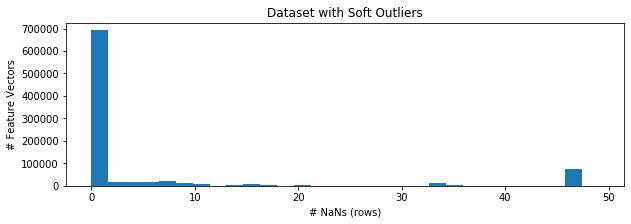

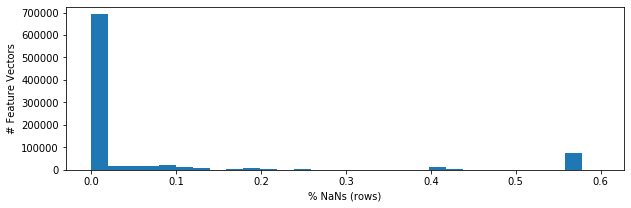

In [21]:
# Plot soft histogram of # NaN 
total_nan_rows = azdias_1.isnull().sum(axis=1)                 
n, bins, patches = plt.hist(total_nan_rows, bins=30)           
plt.ylabel("# Feature Vectors")
plt.xlabel("# NaNs (rows)")  
plt.title('Dataset with Soft Outliers')
plt.show()

# Plot soft histogram of % NaN 
ptotal_nan_rows = (azdias_1.isnull().mean(axis=1))
n, bins, patches = plt.hist(ptotal_nan_rows, bins=30)
plt.ylabel('# Feature Vectors')
plt.xlabel('% NaNs (rows)')
plt.show()

#### 🔴Divide data into two subsets based on NaN count

In [22]:
#Divide the data into two subsets based on the number of missing values in each row
sub1_index = list(ptotal_nan_rows[ptotal_nan_rows < 0.3].index)
sub2_index = list(ptotal_nan_rows[ptotal_nan_rows > 0.3].index)

azdias_2 = azdias_1.drop(sub2_index, axis=0)
sub_outliers = azdias_1.drop(sub1_index, axis=0)

In [23]:
# Count Outliers in Rows
print('The number of outliers (rows) is {} (~{}% of the original dataset)'.format(azdias_1.shape[0] - azdias_2.shape[0], round(100*(azdias_1.shape[0] - azdias_2.shape[0])/azdias_1.shape[0])))

The number of outliers (rows) is 93271 (~10% of the original dataset)


🔵
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

#### 🔴Plot 5 columns for both datasets and compare the relative % value count

In [24]:
# Pick 5 random columns with 0 NaN
np.random.seed(42)

s0 = azdias_1.isna().sum()
s1 = s0[(s0 == 0)]
s2 = pd.Series(s1.index)
column_list = s2.sample(5).values


print(column_list)

['GREEN_AVANTGARDE' 'SEMIO_KULT' 'ANREDE_KZ' 'SEMIO_KRIT' 'SEMIO_REL']


In [25]:
def col_diff(col_list):
    for column in col_list:
        fig, axes = plt.subplots(1, 2, figsize=(15, 2))   
        
        # Define barplot for Low NaN Rows (make y-axis percentage so that difference in row vectors is accounted for)
        ax1 = sns.barplot(x=azdias_2[column], 
                          y=azdias_2[column], 
                          data=azdias_2[column], 
                          estimator=lambda x: len(x) / len(azdias_2[column]) * 100, 
                          color='c', ax=axes[0])
        ax1.set(ylabel="Percent")        
        axes[0].set_title('Low NaN Rows')
        axes[0].set_yticks(np.arange(0, 101, 25))
        
        
        # Define barplot for Low NaN Rows (make y-axis percentage so that difference in row vectors is accounted for)
        ax2 = sns.barplot(x=sub_outliers[column], 
                          y=sub_outliers[column], 
                          data=sub_outliers[column], 
                          estimator=lambda x: len(x) / len(sub_outliers[column]) * 100, 
                          color='r', ax=axes[1])
        ax2.set(ylabel="Percent")  
        axes[1].set_title('High NaN Rows')
        axes[0].set
        axes[1].set_yticks(np.arange(0, 101, 25))
        
        plt.show()

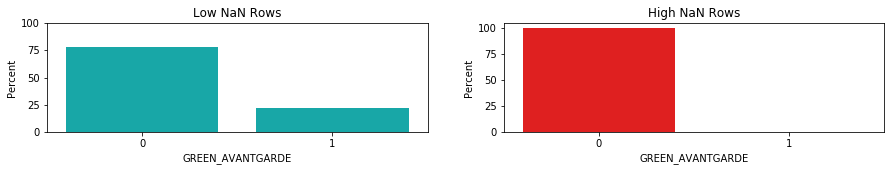

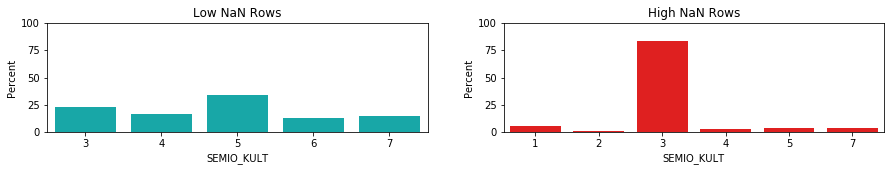

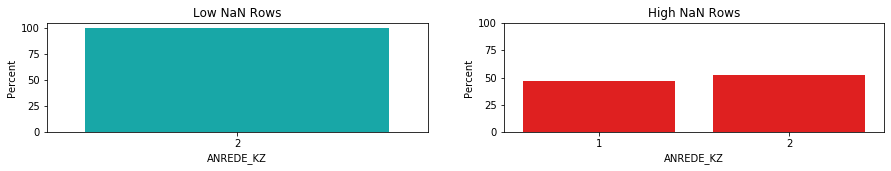

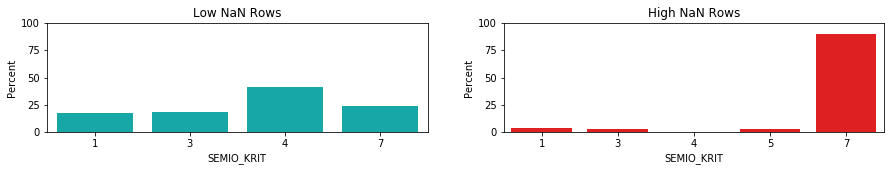

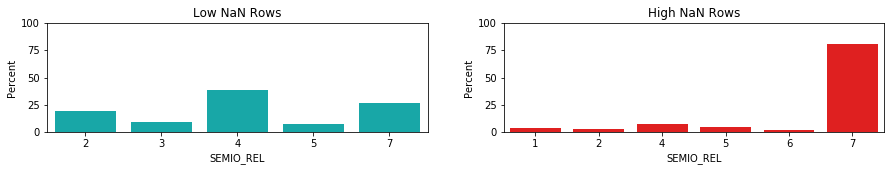

In [26]:
col_diff(column_list)

#### 🟡🟡🟡Discussion 1.1.3: Assess Missing Data in Each Row

Reporting your observations regarding missing data in rows. 

- Are the data with lots of missing values are qualitatively different from data with few or no missing values?

Firstly, we noticed that about 10% of the rows have more than 30% NaNs. Then, we split the dataset into two subsets based on that threshold. 

From the plots we observe that the data vary significantly between the two subsets (for all 5 features that were picked at random). Thus, we conclude that removing the rows that are high in NaN values might lead to unwanted bias. 

## 🔵🔵Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# Number of features for each data type
display(pd.DataFrame({'Type': feat_info_1['type'].value_counts().index, 'Count': feat_info_1['type'].value_counts().values}))

,Type,Count
0,ordinal,49
1,categorical,19
2,mixed,7
3,numeric,6
4,interval,1


#### 🔵Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

#### 🔴Extract Categorical Features

In [28]:
# Extract categorical features
categorical = feat_info_1[feat_info['type'] == 'categorical']['attribute'].values
# Extract their unique value count
categorical_values = pd.DataFrame(azdias_2[categorical].nunique(dropna=True), columns=['Unique Values'])

# Extract Mixed features
mixed = feat_info_1[feat_info_1['type'] == 'mixed']['attribute'].values

C:\Users\johng\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [29]:
display(categorical_values)

,Unique Values
ANREDE_KZ,2
CJT_GESAMTTYP,6
FINANZTYP,6
GFK_URLAUBERTYP,12
GREEN_AVANTGARDE,2
LP_FAMILIE_FEIN,12
LP_FAMILIE_GROB,6
LP_STATUS_FEIN,10
LP_STATUS_GROB,5
NATIONALITAET_KZ,3


#### 🔴Extract Binary & Multi-Level Categorical Features

In [30]:
binary_categorical = categorical_values[categorical_values['Unique Values'] == 2]
multi_categorical = categorical_values[categorical_values['Unique Values'] > 2]

In [31]:
print('There are {} binary categorical features and {} multi-level categorical features.\n'.format(len(binary_categorical), len(categorical)-len(binary_categorical)))
print('Binary:\n')
display(binary_categorical)
print('Multi-Level:\n')
display(multi_categorical)

There are 5 binary categorical features and 14 multi-level categorical features.

Binary:



,Unique Values
ANREDE_KZ,2
GREEN_AVANTGARDE,2
SOHO_KZ,2
VERS_TYP,2
OST_WEST_KZ,2


Multi-Level:



,Unique Values
CJT_GESAMTTYP,6
FINANZTYP,6
GFK_URLAUBERTYP,12
LP_FAMILIE_FEIN,12
LP_FAMILIE_GROB,6
LP_STATUS_FEIN,10
LP_STATUS_GROB,5
NATIONALITAET_KZ,3
SHOPPER_TYP,4
TITEL_KZ,6


#### 🔴Extract Numerical & Non-numerical Features

In [32]:
numerical = []
non_numerical = []

for i, dtype in zip(feat_info_1.index, azdias_1.dtypes):
    if dtype == object:
        non_numerical.append(feat_info_1['attribute'][i])
    else:
        numerical.append(feat_info_1['attribute'][i])
        
# Check if dimensions check out with original dataset
if (len(numerical) + len(non_numerical)) == azdias_1.shape[1]:
    print('Checks out')
else:
    print('Something\'s wrong')

Checks out


In [33]:
# Check if all binary categoricals are numericals
for feature in binary_categorical.index:
    if feature in non_numerical:
        print('{} is non-numerical!'.format(feature))

OST_WEST_KZ is non-numerical!


#### 🔴Encode OST_WEST_KZ

In [34]:
azdias_2["OST_WEST_KZ"] = azdias_2["OST_WEST_KZ"].map({"W": 1, "O": 2}, na_action="ignore")

#### 🔴Examine Correlation between multi-level features to determine which are safe to remove

In [35]:
multilevel = pd.DataFrame(azdias_2[multi_categorical.index])
corr = multilevel.corr()
display(corr[corr > 0.8])


,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,TITEL_KZ,ZABEOTYP,GEBAEUDETYP
CJT_GESAMTTYP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FINANZTYP,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GFK_URLAUBERTYP,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LP_FAMILIE_FEIN,NaN,NaN,NaN,1.000000,0.986208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LP_FAMILIE_GROB,NaN,NaN,NaN,0.986208,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LP_STATUS_FEIN,NaN,NaN,NaN,NaN,NaN,1.000000,0.985804,NaN,NaN,NaN,NaN,NaN
LP_STATUS_GROB,NaN,NaN,NaN,NaN,NaN,0.985804,1.000000,NaN,NaN,NaN,NaN,NaN
NATIONALITAET_KZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
SHOPPER_TYP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
TITEL_KZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [36]:
display(corr[corr < -0.8])

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,TITEL_KZ,ZABEOTYP,GEBAEUDETYP
CJT_GESAMTTYP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FINANZTYP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GFK_URLAUBERTYP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LP_FAMILIE_FEIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LP_FAMILIE_GROB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LP_STATUS_FEIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LP_STATUS_GROB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NATIONALITAET_KZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SHOPPER_TYP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TITEL_KZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 🔴Drop Highly Correlated Multi-Level Features

`LP_FAMILIE_FEIN` and `LP_FAMILIE_GROB` are very highly correlated, as well as `LP_STATUS_FEIN` and `LP_STATUS_GROB`. Thus, we decide to drop `LP_FAMILIE_FEIN` and `LP_STATUS_FEIN`.

In [37]:
drop = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']                  # Feature names to be dropped

azdias_2 = azdias_2.drop(drop, axis=1)                        # Drop from azdias
multi_categorical = multi_categorical.drop(drop, axis = 0)    # Drop from multilevel categoricals

#### 🔴One-Hot Encode Multi-Level Categorical Features

In [38]:
multilevel_names = multi_categorical.index

# Check datatypes
azdias_2[multilevel_names].dtypes

CJT_GESAMTTYP       float64
FINANZTYP             int64
GFK_URLAUBERTYP     float64
LP_FAMILIE_GROB     float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
TITEL_KZ            float64
ZABEOTYP              int64
GEBAEUDETYP         float64
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

*In order to one-hot encode we will turn them into strings

In [40]:
azdias_onehot = pd.get_dummies(azdias_2[multilevel_names].astype('str'))

azdias_3 = azdias_2.drop(multilevel_names, axis=1)

azdias_3 = pd.concat([azdias_3, azdias_onehot], axis=1)

In [41]:
print('One-hot encoding added {} features. Total features: {}.'.format(azdias_3.shape[1]-azdias_2.shape[1], azdias_3.shape[1]))

One-hot encoding added 110 features. Total features: 190.


#### 🔴Remove NaN Columns

In [42]:
nan_columns = [column for column in azdias_3.columns.tolist() if column[-4:] == "_nan"]
azdias_3 = azdias_3.drop(columns=nan_columns)

print('Total features: {}.'.format(azdias_3.shape[1]))

Total features: 182.


#### 🟡🟡🟡Discussion 1.2.1: Re-Encode Categorical Features

In the analysis we found 5 binary and 14 multi-level categoricals. One of the binaries was non-numerical so it was engineered to contain numerical data. **All but two** multi-level categoricals were one-hot encoded to ensure that no potentially useful information is lost. 

(LP_FAMILIE_GROB and LP_STATUS_FEIN were dropped due to their high correlation (> 0.98) with LP_FAMILIE_FEIN and LP_STATUS_GROB respectively.)

**One-Hot Encoding**

Since we turned all one-hot encoding values into string before the encoding, for the columns that contained at least 1 NaN there was a "nan" dummy variable created. Sometimes, NaNs can be meaningful and hold valuable information, but here since no such pattern is obvious (and we already got a lot of data) we dropped the extra NaN columns.

#### 🔵Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE"
- "CAMEO_INTL_2015" 


If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

#### 🔴Define Function to engineer the two mixed features

In [43]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015"
display(pd.DataFrame(azdias_3['PRAEGENDE_JUGENDJAHRE'].head()))
display(pd.DataFrame(azdias_3['CAMEO_INTL_2015'].head(5)))

,PRAEGENDE_JUGENDJAHRE
1,14.0
2,15.0
3,8.0
4,8.0
5,3.0


,CAMEO_INTL_2015
1,51
2,24
3,12
4,43
5,54


In [44]:
def mixed_engineering(df):
    df1 = df['PRAEGENDE_JUGENDJAHRE']
    df2 = df['CAMEO_INTL_2015']

    # Define mapping dictionary for the first feature
    df1_map = {
                1.0:  [40, 1], 2.0:  [40, 2],  3.0: [50, 1],  4.0: [50, 2],  5.0: [60, 1],
                6.0:  [60, 2], 7.0:  [60, 2],  8.0: [70, 1],  9.0: [70, 2], 10.0: [80, 1], 
                11.0: [80, 2], 12.0: [80, 1], 13.0: [80, 2], 14.0: [90, 1], 15.0: [90, 2]
    }

    # Define new decade and movement features for the first feature
    decade = df1.map(lambda x: df1_map[x][0], na_action='ignore')
    decade = decade.rename('DEKADE')
    
    movement = df1.map(lambda x: df1_map[x][1], na_action='ignore')
    movement = movement.rename('TRUPPENBEWEGUNG')
    
    # Define new wealth and life_stage features for the second feature
    wealth = df2.map(lambda x: int(x) // 10, na_action='ignore')
    wealth = wealth.rename('WEALTH')
    
    life_stage = df2.map(lambda x: int(x) % 10, na_action='ignore')
    life_stage = life_stage.rename('LIFE_STAGE')  
    
    # Remove mixed features and add new features to df
    df = df.drop(columns=[df1.name, df2.name])
    df[decade.name] = decade
    df[movement.name] = movement
    df[wealth.name] = wealth
    df[life_stage.name] = life_stage
    
    return df

In [45]:
azdias_3 = mixed_engineering(azdias_3)

In [46]:
display(azdias_3[['DEKADE', 'TRUPPENBEWEGUNG', 'WEALTH', 'LIFE_STAGE']].head())

,DEKADE,TRUPPENBEWEGUNG,WEALTH,LIFE_STAGE
1,90.0,1.0,5.0,1.0
2,90.0,2.0,2.0,4.0
3,70.0,1.0,1.0,2.0
4,70.0,1.0,4.0,3.0
5,50.0,1.0,5.0,4.0


#### 🟡🟡🟡Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
- `"PRAEGENDE_JUGENDJAHRE"` combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we created two new variables to capture the other two dimensions: an interval-type variable for decade (40s - 90s), and a binary variable for movement (1, 2). 
- `"CAMEO_INTL_2015"` combines information on two axes: wealth and life stage. We broke up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables, `wealth` and `life_stage`.

#### 🔵Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

#### 🔴Confirm that columns check out

In [47]:
# Do whatever you need to in order to ensure that the dataframe only contains the columns that should be passed to the algorithm functions.


# Check that binary categorical feature is indeed numerical
print('Binary categorical dtype: ', azdias_3['OST_WEST_KZ'].dtypes)

# Check that the two mixed features were successfully dropped
assert 'PRAEGENDE_JUGENDJAHRE' not in azdias_3.columns
assert 'CAMEO_INTL_2015' not in azdias_3.columns

# Check that the two mixed features were successfully replaced
assert 'DEKADE' in azdias_3.columns
assert 'TRUPPENBEWEGUNG' in azdias_3.columns
assert 'WEALTH' in azdias_3.columns
assert 'LIFE_STAGE' in azdias_3.columns

# Check that dependent features were successfully dropped 
if ('LP_FAMILIE_GROB' not in azdias_3.columns) and ('LP_STATUS_FEIN' not in azdias_3.columns):
    print('Everything appears to be fine!')

Binary categorical dtype:  int64
Everything appears to be fine!


### 🔵🔵Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

#### 🔴Create Dataset Cleaning Function

In [48]:
def clean_data(df):
    '''
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    '''
    
    # Convert missing value codes into NaNs
    df = df.apply(convert_nan)
    
    # Remove hard outliers (Columns)
    df = df.drop(outliers_index, axis=1)

    
    # Remove outliers (rows with more than 30% NaN) 
    p_nan = df.isna().mean(axis=1)
    high_nan = list(p_nan[p_nan > 0.3].index)
    df = df.drop(high_nan, axis=0)

    
    # Re-encode OST_WEST_KZ (numerical values)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 2}, na_action='ignore')

    
    # Drop dependent multi-level features
    df = df.drop(columns=["LP_FAMILIE_FEIN", "LP_STATUS_FEIN"])
    
    # One-hot encode multi-level features
    df_onehot = pd.get_dummies(df[multilevel_names].astype('str'))
    
    df_temp = df.drop(multilevel_names, axis=1)
    
    df = pd.concat([df_temp, df_onehot], axis=1)
    
    # Remove nan columns (resulting from one-hot encoding)
    nan_cols = [column for column in df.columns.tolist() if column[-4:] == "_nan"]
    df = df.drop(columns=nan_cols)
    
    # Engineer new features from mixed ones
    df = mixed_engineering(df)
    
    return df

# 🔵🔵🔵Step 2: Feature Transformation

## 🔵🔵Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

**Useful Imports**

In [49]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#### 🔴Calculate percentage of NaN

In [50]:
# Count % NaN
total_values = azdias_3.shape[0] * azdias_3.shape[1]
total_nan = azdias_3.isna().sum().sum()

print('The dataset consists {:.2f}% of NaN values.'.format(100*total_nan/total_values))

The dataset consists 0.50% of NaN values.


#### 🔴Deal with NaN values (using an Imputer)

Using an imputer, we have the ability to replace NaN values with other values of our liking. 
A good tactic could be to replace NaN values with the median of that column, but this may lead to unreasonable, non-integer values for categorical data.

In [51]:
# Fit-transform imputer to dataset
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer_fit = imputer.fit(azdias_3)
imputer_transform = imputer_fit.transform(azdias_3)

# Create dataset with 0 NaNs
azdias_4 = pd.DataFrame(imputer_transform, columns=azdias_3.columns)

# Check if process was successful
if azdias_4.isna().sum().sum() == 0:
    print('Jolly good!')

Jolly good!


#### 🔴Apply feature scaling (standardisation)

In [52]:
# Apply feature scaling to the general population demographics data
scaler = StandardScaler()
scaler_fit = scaler.fit(azdias_4)
scaler_transform = scaler_fit.transform(azdias_4)
azdias_5 = pd.DataFrame(scaler_transform, columns=azdias_4.columns)

In [53]:
# Quickly check whether head() values are reasonable
azdias_5.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DEKADE,TRUPPENBEWEGUNG,WEALTH,LIFE_STAGE
0,-1.766595,0.957919,-1.494584,1.537956,-1.040685,1.466015,0.958808,1.339226,-0.530416,1.010180,...,-0.150075,-0.162554,-0.189552,-0.179795,-0.192782,-0.089763,1.098129,-0.530416,1.175683,-1.248968
1,0.200520,0.957919,-1.494584,0.864597,-1.766958,-0.570969,0.244255,1.339226,1.885313,1.010180,...,-0.150075,-0.162554,-0.189552,-0.179795,-0.192782,-0.089763,1.098129,1.885313,-0.869679,0.767021
2,1.184078,0.957919,0.683177,-0.482122,1.138132,-0.570969,-1.184852,-0.791382,-0.530416,-0.311815,...,-0.150075,-0.162554,-0.189552,-0.179795,-0.192782,-0.089763,-0.267708,-0.530416,-1.551467,-0.576972
3,0.200520,-1.043929,0.683177,0.191238,0.411860,-1.249964,0.244255,-0.791382,-0.530416,1.010180,...,-0.150075,-0.162554,-0.189552,-0.179795,-0.192782,-0.089763,-0.267708,-0.530416,0.493895,0.095024
4,-1.766595,0.957919,-0.042744,-1.155481,1.138132,-0.570969,-0.470299,1.339226,-0.530416,1.010180,...,-0.150075,-0.162554,-0.189552,-0.179795,-0.192782,-0.089763,-1.633546,-0.530416,1.175683,0.767021


### 🟡🟡🟡Discussion 2.1: Apply Feature Scaling

#### Missing Values
An imputer was used to deal with NaN values. The missing values were replaced with the most frequent value in their respective column (to avoid unreasonable results in categorical features).

#### Feature Scaling
For feature scaling we simply standardised the data.

## 🔵🔵Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. 
- To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

**Imports**

In [54]:
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score

#### 🔴Create new dataset with PCA 

In [55]:
# Instantiate
pca_test = PCA(azdias_5.shape[1])

# Fit-transform
azdias_pca_test = pca_test.fit_transform(azdias_5)

#### 🔴Create Scree Plot Helper Function
This will help us determine the amount of components that we want using the pca instance we defined above. 

In [56]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT: None
            
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)        # Number of components
    var = pca.explained_variance_ratio_    # Variance explained by each component
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvar = np.cumsum(var)              # Commulative sum of variance explained                 
    ax.bar(ind, var) 
    ax.plot(ind, cumvar)
    

 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("# Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

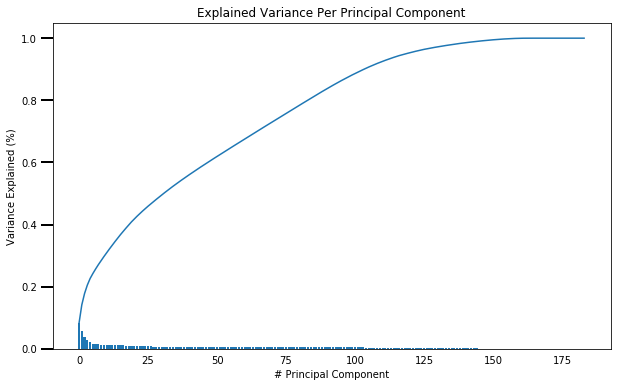

In [57]:
scree_plot(pca_test)

In [58]:
# Number of components
ind = np.arange(len(pca_test.explained_variance_ratio_)) 
# Variance explained by each component
var = pca_test.explained_variance_ratio_
# Commulative sum of variance explained 
cumvar = pd.Series(np.cumsum(var))            

#### 🔴Pick components so that ~80% of variance is explained

In [59]:
# Clip commulative variance series at cutoff variance
cutoff = 0.808                            # Define cutoff
clip1 = cumvar.clip(upper = cutoff)       # Clip
clip2 = clip1[clip1 != cutoff]            # Remove clipped
num_components = len(clip2)               # Return number of principal components to keep
print('To retain ~80% of the information, {} principal components will be used'.format(num_components))

To retain ~80% of the information, 85 principal components will be used


#### 🔴Re-apply PCA
This time for 85 components.

In [60]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(num_components)
azdias_pca = pca.fit_transform(azdias_5)

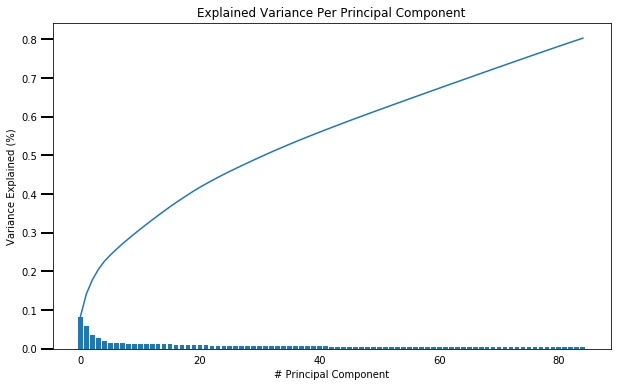

In [61]:
scree_plot(pca)

### 🟡🟡🟡Discussion 2.2: Perform Dimensionality Reduction

- How many principal components / transformed features are you retaining for the next step of the analysis?

I decided to retain 85 principal components since it is the number of components needed to explain 80% of the variance in the data, which seemed like a good cut-off point judging from the rate of change of the variance explained in the scree plot. 

## 🔵🔵Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

#### 🔴Create helper function to display sorted feature weights for a principal component

In [62]:
def interpret_comp(comp, feat_names):
    '''
    Input: principal component (obtained from pca.components_)
    Output: DataFrame containing Feature names and their corresponding weight (for the top 5 positive and negative values)
    '''
    
    # Create feature weights dataframe for given component
    comp_w = pd.DataFrame({'Feature': feat_names, 'Weight': comp})
    
    # Sort the weights in descending order
    comp_w = comp_w.sort_values(by='Weight', ascending=False)
    
    # Crop dataframe to keep 5 first and last rows
    comp_w = pd.concat([comp_w.iloc[0:5, :], comp_w.iloc[-5:, :]])
    
    # Reset indeces
    comp_w = comp_w.reset_index(drop=True)
    
    return comp_w

#### 🔴Use helper function on our top 3 components

In [63]:
# Extract component weights
comp1 = pca.components_[0]
comp2 = pca.components_[1]
comp3 = pca.components_[2]

# Define feature names
feat_names = azdias_5.columns

In [64]:
# Display dataframes
print('------------------------------------\n First component:\n')
display(interpret_comp(comp1, feat_names))
print('------------------------------------\n Second component:\n')
display(interpret_comp(comp2, feat_names))
print('------------------------------------\n Third component:\n')
display(interpret_comp(comp3, feat_names))

------------------------------------
 First component:



,Feature,Weight
0,LP_STATUS_GROB_1.0,0.190499
1,PLZ8_ANTG3,0.186389
2,WEALTH,0.185170
3,HH_EINKOMMEN_SCORE,0.182645
4,PLZ8_ANTG4,0.181476
5,KBA05_ANTG1,-0.179950
6,KBA05_GBZ,-0.182874
7,FINANZ_MINIMALIST,-0.185028
8,PLZ8_ANTG1,-0.187747
9,MOBI_REGIO,-0.188818


------------------------------------
 Second component:



,Feature,Weight
0,ALTERSKATEGORIE_GROB,0.238629
1,FINANZ_VORSORGER,0.224573
2,ZABEOTYP_3,0.204799
3,SEMIO_ERL,0.189055
4,SEMIO_LUST,0.167348
5,SEMIO_TRADV,-0.212995
6,FINANZ_UNAUFFAELLIGER,-0.218484
7,SEMIO_REL,-0.223370
8,FINANZ_SPARER,-0.232019
9,DEKADE,-0.235592


------------------------------------
 Third component:



,Feature,Weight
0,SEMIO_VERT,0.324965
1,SEMIO_SOZ,0.257567
2,SEMIO_FAM,0.256948
3,SEMIO_KULT,0.247760
4,FINANZ_MINIMALIST,0.137270
5,SEMIO_ERL,-0.201718
6,SEMIO_KRIT,-0.271249
7,SEMIO_DOM,-0.291937
8,SEMIO_KAEM,-0.321360
9,ANREDE_KZ,-0.349486


### 🟡🟡🟡Discussion 2.3: Interpret Principal Components

Reporting your observations from detailed investigation of the first few principal components generated. 
- Can we interpret positive and negative values from them in a meaningful way?
------------------------------
### 1st Component
Top 5 **positive** features:

- LP_STATUS_GROB: Social status, rough scale (ascending)
- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
- WEALTH: Wealth (engineered feature)
- HH_EINKOMMEN_SCORE: Estimated household net income
- PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region

Top 5 **negative** features: 

- MOBI_REGIO: Movement patterns
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
- FINANZ_MINIMALIST: Financial typology (descending)
- KBA05_GBZ: Number of buildings in the microcell
- KBA95_ANTG1: Number of 1-2 family houses in the microcell

**Interpretation**: 

This component appears to be associated with a person's wealth (positive correlation), and population density in a given region (positive correlation).

This is because the latent feature is positively correlated with wealth and high-density regions and negatively correlated with low-density regions.

------------------------------
### 2nd Component
Top 5 **positive** features:

- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- FINANZ_VORSORGER: Financial typology (descending)
- ZABEOTYP_3: Energy consumption typology
- SEMIO_ERL: Personality typology (descending affinity)
- SEMIO_LUST: Personality typology (descending affinity)

Top 5 **negative** features:

- DEKADE: Decade of birth
- FINANZ_SPARER: Financial typology (descending)
- SEMIO_REL: Personality typology (descending affinity)
- FINANZ_UNAUFFAELLIGER: Financial typology (descending)
- SEMIO_TRADV: Personality typology

**Interpretation**: 

This component appears to mostly be associated with a person's age (positive correlation). 

Specifically, we can see positive correlation with (fair/average) energy consumption and some personality traits (as well as financial activity).
Negative correlation is with the person's decade of birth and again some financial activity and personality traits. 

------------------------------
### 3rd Component
Top 5 **positive** features:

- SEMIO_VERT: Personality typology (descending affinity)
- SEMIO_SOZ: Personality typology (descending affinity)
- SEMIO_FAM: Personality typology (descending affinity)
- SEMIO_KULT: Personality typology (descending affinity)
- FINANZ_MINIMALIST: Financial typology (descending)

Top 5 **negative** features:

- ANREDE_KZ: Gender (1 male, 2 female)
- SEMIO_KAEM: Personality typology (descending affinity)
- SEMIO_DOM: Personality typology (descending affinity)
- SEMIO_KRIT: Personality typology (descending affinity)
- SEMIO_ERL: Personality typology (descending affinity)

**Interpretation**: 

This component is difficult to decipher due to the lack of insight into its top features. 
It is highly correlated with personality types and appears to distinguish between men and women. 

Specifically, the component points in the direction of male and hence is negatively correlated with the female gender. 

# 🔵🔵🔵Step 3: Clustering

## 🔵🔵Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [113]:
# Import KMeans
from sklearn.cluster import KMeans

#### 🔴Elbow Method 
Here we perform K-Means clustering on our dataset using cluster numbers from 1 to 10. 
Then, we plot the absolute value of the score (average within-cluster distances) to see how the rate of change of the score changes.

Using the elbow method, we will attempt to pick the ideal number of clusters by choosing the point where the rate of change of the score gets significantly closer to 0 abruptly.  

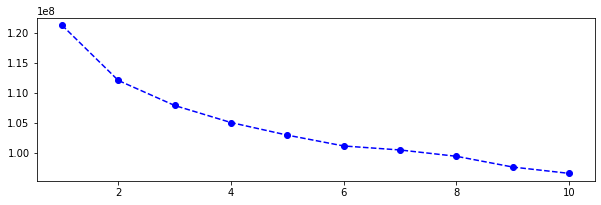

In [74]:
k = np.arange(1, 11, 1)
scores = []

for i in k:
    model = KMeans(i)
    model = model.fit(azdias_pca)
    scores.append(np.abs(model.score(azdias_pca)))

    
plt.plot(k, scores, linestyle='--', marker='o', color='b')
plt.show()

#### 🔴Refit K-Means For 6 Clusters
I chose 6 clusters because 2 seemed too low (for this many latent features) and because we notice a somewhat sudden change in the rate of change of the score (i.e. clusters after that contribute less and less).

In [ ]:
start = time.time()
model = KMeans(6, n_jobs=-1).fit(azdias_pca)
end = time.time()
print('Time taken to fit K-Means: {:.2f}s'.format(end - start))

# Store predictions for step 3.3 
azdias_pred = model.predict(azdias_pca)


In [78]:
azdias_pred

array([3, 3, 2, ..., 4, 5, 0])

### 🟡🟡🟡Discussion 3.1: Apply Clustering to General Population

Into how many clusters have you decided to segment the population? 

(This was mentioned above)


## 🔵🔵Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [96]:
# Load in the customer demographics data
customers = pd.read_csv("data/Udacity_CUSTOMERS_Subset.csv", delimiter=";")

#### 🔴Clean Customer Data and Check Feature Count

In [97]:
# Use cleaning function
customers = clean_data(customers)

In [111]:
# Check dimensions
print('Azdias feature count:    ', azdias_5.shape[1])
print('Customers feature count: ', customers.shape[1])

Azdias feature count:     184
Customers feature count:  184


In [99]:
# Check which columns are missing from the customers dataset
missing_columns = []
for column in azdias_5.columns:
    if column not in customers.columns:
        missing_columns.append(column)
        
print(missing_columns)

['TITEL_KZ_2.0', 'GEBAEUDETYP_5.0']


These are encoded features which did not get encoded in the customers dataset due to their values not being in there at all. 

Thus, we will add the columns to the customers dataset and fill them with 0.

#### 🔴Add Missing Columns to `customers` (one-hot encoding)

In [100]:
for column in missing_columns:
    customers[column] = 0
    
# Check if dimensions now much 
if azdias_5.shape[1] == customers.shape[1]:
    print('All is well!')

All is well!


#### 🔴Deal with NaN values (using the same Imputer object as we did for azdias)


In [109]:
customers_transform = imputer_fit.transform(customers)
customers = pd.DataFrame(customers_transform, columns=customers.columns)

# Check if process was successful
if customers.isna().sum().sum() == 0:
    print('Jolly good! 0 NaN')
else:
    print('Something\'s wrong! There are still {} NaN'.format(customers.isna().sum().sum()))

Jolly good! 0 NaN


#### 🔴Apply feature scaling, PCA, and Clustering to the `customers` dataset

In [115]:
# Feature Scaling
customers_transform = scaler.transform(customers)
customers = pd.DataFrame(data=customers_transform, columns=customers.columns)

# PCA
customers_pca = pca.transform(customers)

# K-Means Clustering
customers_pred = model.predict(customers_pca)

NameError: name 'model' is not defined

## 🔵🔵Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### 🟡🟡🟡Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.